In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
"""
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

'\nimport numpy as np # linear algebra\nimport pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)\n\n# Input data files are available in the read-only "../input/" directory\n# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory\n\nimport os\nfor dirname, _, filenames in os.walk(\'/kaggle/input\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n'

# I'm Something of a Painter Myself - TensorFlow
https://github.com/Lorviina/MastersofScienceDataScience

In [1]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# List all available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU devices found.")

2 Physical GPUs, 2 Logical GPUs


In [3]:
data_dir = '/kaggle/input/gan-getting-started'
files = os.listdir(data_dir)
print(files)
monet_images_path = os.path.join(data_dir,'monet_jpg')
photo_images_path = os.path.join(data_dir, 'photo_jpg')
monet_tfrec_path = os.path.join(data_dir, 'monet_tfrec')
photo_tfrec_path = os.path.join(data_dir, 'photo_tfrec')

['monet_jpg', 'photo_tfrec', 'photo_jpg', 'monet_tfrec']


# **My plan and feedback from GPT:**

**Step 1: Load the Data**
Your approach to loading data by specifying paths to different types of files (JPEGs and TFRecords) is straightforward and effective for organizing your data sources. This step is crucial for setting up the subsequent data handling and processing.

Feedback:Ensure that the paths are correct and that the datasets are indeed structured as expected (directories for images and TFRecord files).
Consider verifying the contents of each directory after setting the paths to ensure that data loading will proceed without issues.

**Step 2: Print Some Images**
Visualizing the data is an excellent step to understand what you're working with and to ensure that the data loading is correct.

Feedback: Use image display libraries such as matplotlib.pyplot or PIL (Python Imaging Library) to visualize the images.
It might be helpful to display a few images from each category side by side to directly compare the styles of Monet paintings versus regular photos.

**Step 3: Create a GAN Structure**
Selecting the right framework and architecture for your GAN is essential. Common choices include TensorFlow with Keras, or PyTorch.

Feedback: Decide early on which framework you are more comfortable with or which has better support for your specific needs (e.g., TensorFlow for TPUs on Kaggle).
Start with a simple GAN architecture and gradually increase complexity as needed.

**Step 4: Train the Model**
Training the GAN on both Monet paintings and photos while distinguishing between the two is a good approach to teach the model the specific style of Monet.

Feedback: Consider using different labels for Monet images and photos during training to help the discriminator learn the differences more effectively.
Monitor the training process closely using loss metrics and periodically generated images to ensure the model is learning appropriately.

**Step 5: Revise/Hyperparameter Tune**
Iterative improvement through tuning is vital for achieving good results with GANs, which are notoriously sensitive to parameter settings.

Feedback: Be prepared to experiment with different learning rates, batch sizes, and other architectural parameters. Use validation performance as a guide—not just loss values but visual inspection of generated images.

**Step 6: Generate Results**
Generating and evaluating the final results will be the ultimate test of how well your GAN has learned to imitate Monet's style.

Feedback: Consider setting up a quantitative metric for evaluating image quality if possible (e.g., Inception Score, FID). Also, get subjective feedback on the generated images' quality by visual inspection or peer review.

## Step Two: Visualise some of the data

In [4]:
def display_sample_images(path, title, num_images=3):
    # Ensure the path exists and is a directory
    if not os.path.isdir(path):
        print(f"Directory {path} does not exist.")
        return

    # Get all files in the directory
    files = os.listdir(path)
    plt.figure(figsize=(10, 10))
    for i, file in enumerate(files[:num_images]):
        # Construct full image path
        img_path = os.path.join(path, file)
        # Open and display the image
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

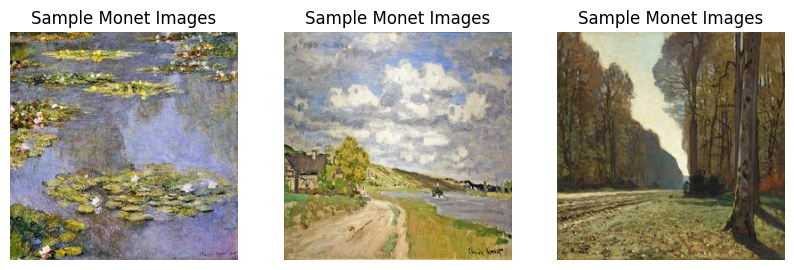

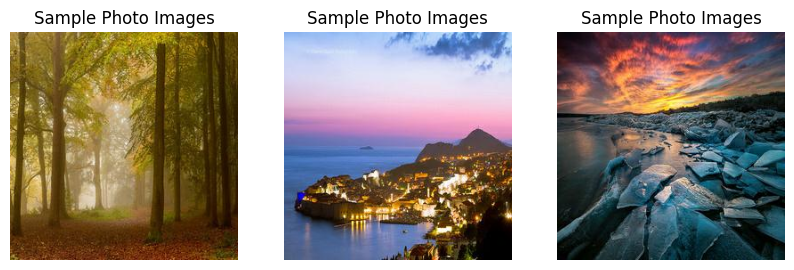

In [5]:
# Display some Monet paintings
display_sample_images(monet_images_path, 'Sample Monet Images')

# Display some photo images
display_sample_images(photo_images_path, 'Sample Photo Images')

In [8]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)  # Convert the compressed string to a 3D uint8 tensor
    img = tf.image.resize(img, [256, 256])       # Resize the image to the desired size
    return (img / 127.5) - 1                     # Normalize the image to [-1, 1]

def process_path(file_path):
    img = tf.io.read_file(file_path)             # Load the raw data from the file as a string
    img = decode_img(img)
    return img

def load_dataset(path, batch_size=16):
    if not os.path.exists(path):
        print(f"Directory {path} does not exist.")
        return None
    dataset = tf.data.Dataset.list_files(os.path.join(path, '*.jpg'))
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)  # Optional: Shuffle the dataset
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(tf.data.AUTOTUNE)



In [9]:
photo_dataset = load_dataset(photo_images_path, batch_size=16)
monet_dataset = load_dataset(monet_images_path, batch_size=16)

if photo_dataset is not None and monet_dataset is not None:
    print("Datasets loaded successfully.")
else:
    print("Failed to load one or more datasets.")

Datasets loaded successfully.


## Step Three: GAN Structure
In this step I want to setup the basic components of a GAN, including the generator and a discriminator. The generator will create the images, while the discriminator evaluates them. I have chosen to use the tensorflow and keras packages due to their accessability and power for image processing tasks.

In [10]:
from tensorflow.keras import layers, Model

### 3.1 Define the Generator and Discriminator
The generator will take a random noise vector as input and produce an image output. The discriminator will take an image as input and output a single scalar that estimates whether the input image is real (from the dataset) or fake (generated).

### 3.2 Initialise the Models

In [12]:
# Constants
LAMBDA = 10  # Weight for cycle consistency losses
epochs = 10  # Number of training epochs

In [13]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    block = tf.keras.Sequential()
    block.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        block.add(layers.BatchNormalization())
    block.add(layers.LeakyReLU())
    return block

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    block = tf.keras.Sequential()
    block.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_dropout:
        block.add(layers.Dropout(0.5))
    block.add(layers.BatchNormalization())
    block.add(layers.ReLU())
    return block

def Generator():
    inputs = layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02), activation='tanh')
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    x = last(x)
    return Model(inputs=inputs, outputs=x)

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp
    x = downsample(64, 4, False)(x)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)
    return Model(inputs=inp, outputs=x)




In [14]:
def generator_loss(disc_generated_output):
    return tf.reduce_mean(tf.losses.binary_crossentropy(tf.ones_like(disc_generated_output), disc_generated_output, from_logits=True))

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.reduce_mean(tf.losses.binary_crossentropy(tf.ones_like(disc_real_output), disc_real_output, from_logits=True))
    generated_loss = tf.reduce_mean(tf.losses.binary_crossentropy(tf.zeros_like(disc_generated_output), disc_generated_output, from_logits=True))
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image))

In [15]:
# Define models
generator_g = Generator()
generator_f = Generator()
discriminator_x = Discriminator()
discriminator_y = Discriminator()

# Define optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Use models directly
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Compute losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        total_cycle_loss = cycle_consistency_loss(real_x, cycled_x) + cycle_consistency_loss(real_y, cycled_y)
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, fake_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, fake_x)
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

        # Compute gradients
        generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
        discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

        # Apply gradients
        generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
        generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
        discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
        discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

## Step Four: Model Setup and Training
It took me a while to utilise the GPU for model training. 

In [17]:
for epoch in range(epochs):
    for real_x, real_y in zip(photo_dataset, monet_dataset):
        if real_x.shape[0] != real_y.shape[0]:
            min_batch_size = min(real_x.shape[0], real_y.shape[0])
            real_x = real_x[:min_batch_size]
            real_y = real_y[:min_batch_size]
        train_step(real_x, real_y)
    print(f"Epoch {epoch+1} completed")

2024-10-15 10:04:49.389533: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_33_3/sequential_23_1/dropout_3_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed


In [19]:
import zipfile

# Assuming 'generator' is your trained model
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1  # Normalize the image to [-1, 1]
    return image

def save_image(image, filename):
    image = (image + 1) * 127.5  # Convert back to [0, 255]
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image)
    tf.io.write_file(filename, image)

def display_images(images, titles, n=10):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(images[i] * 0.5 + 0.5)  # Convert back from [-1,1] to [0,1]
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

In [24]:
# Define the path for the temporary output directory
tmp_output_path = '/kaggle/tmp'
os.makedirs(tmp_output_path, exist_ok=True)

# Path to save the zip file
zip_filename = '/kaggle/working/images.zip'

# Initialize the ZIP file
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    # Assuming photo_images_path is properly defined and contains input images
    # Generate images
    for i in range(7000, 10001):  # Adjust range as needed based on the number of images you plan to generate
        # Generate a synthetic input or use an existing image transformed
        # This is a placeholder for image generation logic
        # original_img should be a preprocessed image tensor of the correct dimensions
        original_img = tf.random.normal([1, 256, 256, 3])  # Example placeholder for an image input

        # Generate Monet-style image using generator_g
        monet_img = generator_g(original_img, training=False)
        monet_img = tf.squeeze(monet_img, 0)  # Remove batch dimension

        # Convert tensor to image format
        monet_img = (monet_img * 127.5 + 127.5).numpy().astype('uint8')  # Adjust normalization as per your model's training

        # Create a file-like object from image data
        img_filename = f"monet_{i}.jpg"
        img_path = os.path.join(tmp_output_path, img_filename)
        tf.keras.preprocessing.image.save_img(img_path, monet_img)
        
        # Write the image to the ZIP file
        zipf.write(img_path, arcname=img_filename)

print("All images have been generated and zipped successfully!")

All images have been generated and zipped successfully!
